## Приоритизация гипотез.

### Импорт библиотек, знакомство с данными

In [1]:
import pandas as pd
import math as mth
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display
from scipy import stats as st

sns.set_style("whitegrid")
pd.set_option("max_colwidth", 100)


In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


### Работа с ICE и RICE

Рассчитаем метрику ICE для приоритезации задач.

Формула расчета ICE выглядит следующим образом: $$ ICE = \frac {Impact * Confidence}{Efforts} $$

In [4]:
hypothesis["ICE"] = hypothesis["Impact"] * hypothesis["Confidence"]/hypothesis["Efforts"]

In [5]:
print(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

                                                                                            Hypothesis  \
8                                              Запустить акцию, дающую скидку на товар в день рождения   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                     Изменить цвет фона главн

В лидерах оказались задачи с индексами 8, 0,7 и 6.

Теперь рассмотрим метрику RICE.

Формула расчета RICE выглядит следующим образом: $$ RICE = \frac {Reach * Impact * Confidence}{Efforts} $$

In [6]:
hypothesis["RICE"] = hypothesis["Reach"] * hypothesis["Impact"] * hypothesis["Confidence"]/hypothesis["Efforts"]

In [7]:
print(hypothesis[['Hypothesis','RICE']].sort_values(by='RICE', ascending=False))

                                                                                            Hypothesis  \
7     Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...   
0   Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6  Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...   
8                                              Запустить акцию, дающую скидку на товар в день рождения   
3  Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                            Запустить собственную службу доставки, что сократит срок доставки заказов   
5             Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
4                     Изменить цвет фона главн

Отметим, что в топ-5 находятся гипотезы с индексом 7,2,0,6,8 - их необходимо будет проверить в каком-либо порядке. 

А гипотезы 1,5,3,4 имеют низкий балл. Их проверкой можно не заниматься.

Заметим, что разброс значений, рассчитанных по RICE гораздо выше, чем по ICE.

### Вывод

По данным методам приоритезации делаем вывод, что необходимо сосредоточиться на рассмотрении гипотез 8,0,6,7,2. 

А гипотезы 3,1,5,4 можно не рассматривать, их влияние на бизнес слишком мало.

## Анализ A/B-теста


### Знакомство с данными, предварительная обработка

Загрузим данные в датафреймы.

In [9]:
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Для датафрейма `orders` изменим тип даты с `object` на `datetime64`.

In [10]:
display(orders)

orders['date'] = pd.to_datetime(orders['date'])

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


В связи с тем, что параметр `revenue` отражает важную характеристику, необходимо ознакомиться с ним получше перед началом анализа.

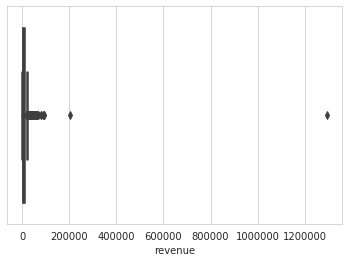

In [11]:
sns.boxplot(x=orders['revenue'], linewidth=2.5)

In [12]:
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Построенный boxplot, а также подрбоное описание столбца `revenue` методом `describe()` показывет, что мы имеем дело с аномальными величинами, которые способны исказить исследование. В рамках поставленной задачи мы не можем сразу исключать эти данные, поэтому проигнорируем данный факт.

Посмотрим также на распределение по каждой группе.

In [13]:
orders_brief = orders.groupby(['group','visitorId'], as_index=False).agg({'revenue':'count'})

Датафрейм `orders_brief` построен методом `groupby`. Если сейчас мы попробуем найти количество дубликатов по столбцу visitorId, то мы сможем выяснить, корректино ли делился трафик между покупателями.

In [14]:
print('Количество дубликатов в visitorId - {}'.format(orders_brief['visitorId'].duplicated().sum()))

Количество дубликатов в visitorId - 58


Получается, что существует околов 58 строк-дубликатов, что для A/B-теста является ошибкой. 

При этом сделаем вывод, что это 58 дублирующихся строк только в покупателях. Что же тогда происходит с посетителями?

Теперь рассмотрим датафрейм `visitors`. Также приведем в порядок тип для столбца `date`.

In [15]:
display(visitors)

visitors['date'] = pd.to_datetime(visitors['date'])

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [16]:
groups_visitors = visitors.groupby('group').agg({'visitors': 'sum'})
display(groups_visitors)

,visitors
group,
A,18736
B,18916


В датафрейме `visitors` хранится информация о посещениях. Группы в данной таблице отличаются по количеству, чего быть не должно.

### Анализ данных

Начинаем анализ.

Рассчитаем агрегированные значения по посещениям и по заказам.

In [17]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': pd.Series.nunique,
            'visitorId': pd.Series.nunique,
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


Объединим данные для исследования. После этого разделим их на выборки.

In [18]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeData['conversion'] = (
    cumulativeData['orders'] / cumulativeData['visitors']
)

cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']



Теперь построим график сранения кумулятивных значений выручки по группам A и B.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


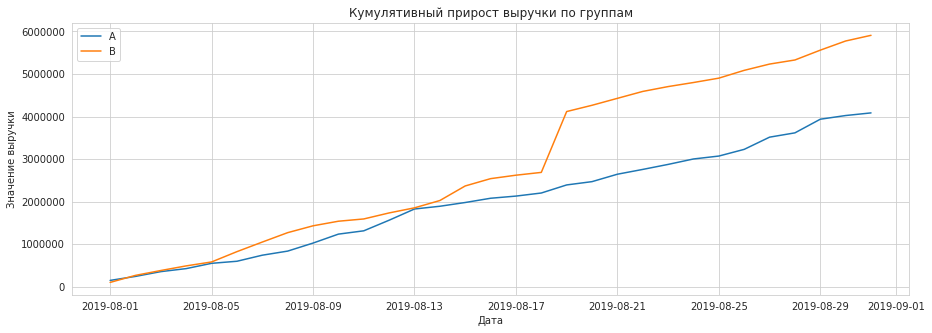

<function matplotlib.pyplot.close(fig=None)>

In [19]:
plt.figure(figsize=(15,5))
plt.title('Кумулятивный прирост выручки по группам')
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue'], label="A")
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue'], label="B")
plt.xlabel('Дата')
plt.ylabel('Значение выручки')
plt.legend()
plt.show()
plt.close

На графике видим, что группа B по вычуке опережает группу A на протяжении всего времени исследования. Однако, также из графика видно, что в 19-08 у группы B произошел аномальный скачок выручки, который надо исследовать.

В рамках данного проекта, аномальные значения предполагается исключить позже. Поэтому оставим данный пункт и пойдём далее.

Теперь построим график кумулятивного среднего чека по группам. 

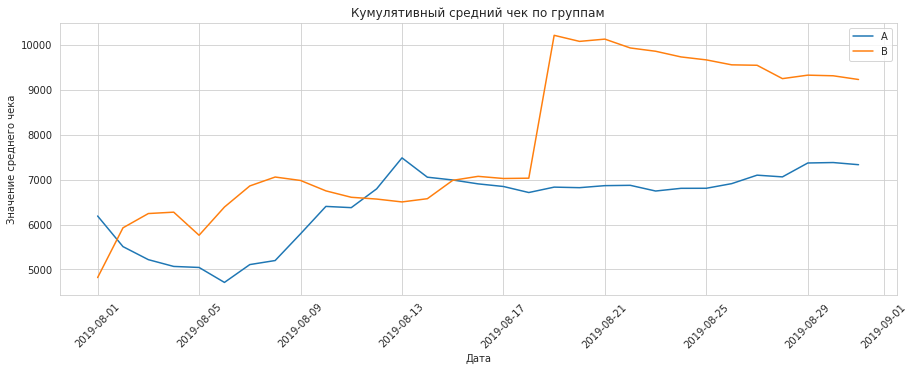

In [20]:
plt.figure(figsize=(15,5))
plt.title('Кумулятивный средний чек по группам')
plt.plot(cumulativeDataA['date'], cumulativeDataA['revenue']/cumulativeDataA['orders'], label="A")
plt.plot(cumulativeDataB['date'], cumulativeDataB['revenue']/cumulativeDataB['orders'], label="B")
plt.xlabel('Дата')
plt.ylabel('Значение среднего чека')
plt.legend()
plt.xticks(rotation=45)
plt.show()
plt.close()

Значение среднего чека у группы B также больше, чем у группы A. Однако, есть периоды, в которых значение среднего чека падает. 

Отметим также, что тенденция к снижению значения среднего чека после 19-08 для группы B вызвано аномальным ростом выручки за 1 день - после этого дня выручка не росла и не оставалась на одном уровне, поэтому значение среднего чека стало уменьшаться.

Построим график кумулятивной конверсии по группам.

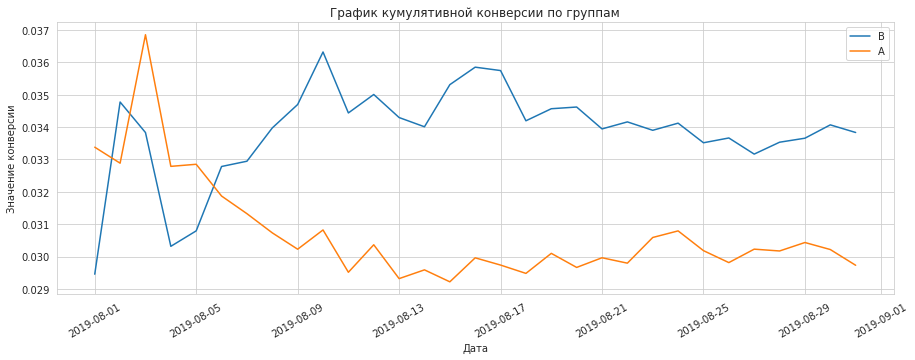

In [21]:
plt.figure(figsize=(15,5))
plt.title('График кумулятивной конверсии по группам')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label="B")
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label="A")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение конверсии')
plt.xticks(rotation=30)
plt.show()
plt.close()

Таким образом, конверсия по группе А меньше конверсии по группе B большую часть времени.

Построим график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

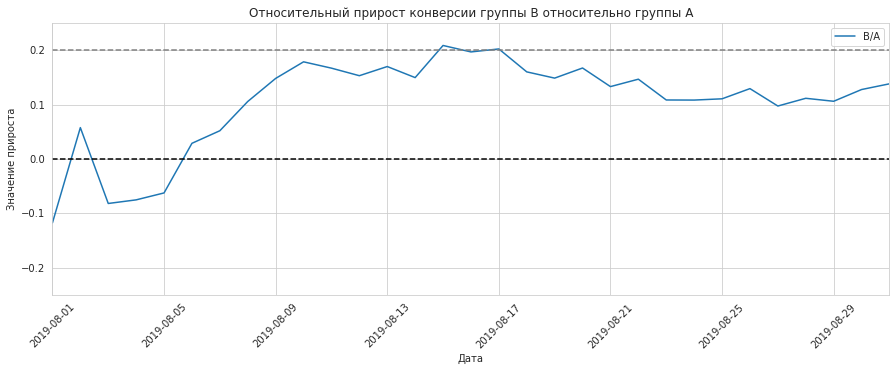

In [22]:
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

plt.figure(figsize=(15,5))
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="B/A")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение прироста')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.25, 0.25])
plt.xticks(rotation=45)
plt.show()
plt.close()

На протяжении большей части исследования прирост конверсии группы B относительно группы А был положительным. Под конец исследования он закрепился на уровне выше 0.1.

Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.


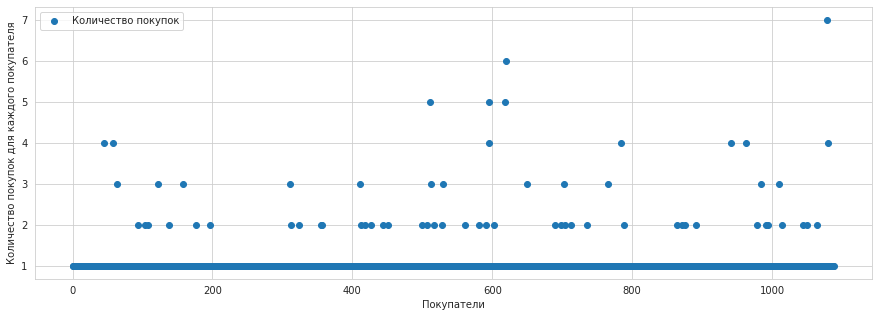

In [23]:
users = orders.groupby(['visitorId', 'group']).agg({'revenue':'count'})
users = users.rename(columns={'revenue':'number_of_orders'})


x_values = pd.Series(range(0,len(users['number_of_orders'])))

plt.figure(figsize=(15,5))
plt.scatter(x = x_values, y='number_of_orders',data=users, label="Количество покупок") 
plt.legend()
plt.ylabel("Количество покупок для каждого покупателя")
plt.xlabel('Покупатели')
plt.show()
plt.close()

На графике видим, что большинство покупок - единичные. Совсем мало случаев, когда покупок больше 4. Видимо, рассматриваемый интернет-ресуср сосредоточен на единичных покупках. Или у него всё плохо с возвращением покупателей.

Посмотрим на 95 и 99-ые перцентили. 

In [24]:
print(users['number_of_orders'].quantile([.95,.99]))

0.95    2.0
0.99    4.0
Name: number_of_orders, dtype: float64


99 перцентилю соответствует 4 заказа, а 95-ому - всего лишь 2. Установим аномальной границей количество заказов больше двух.

Теперь построим точечный график стоимостей заказов.

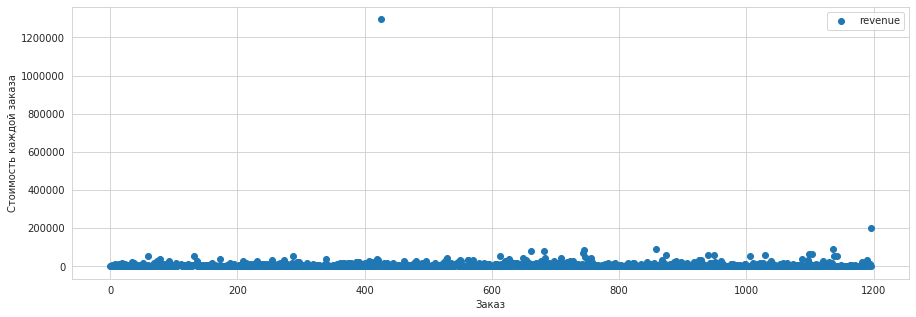

In [25]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(15,5))
plt.scatter(x = x_values, y='revenue',data=orders) 
plt.legend()
plt.ylabel("Стоимость каждой заказа")
plt.xlabel('Заказ')
plt.show()
plt.close()

Посчитаем таким же образом перцентили.

In [26]:
print(orders['revenue'].quantile([.95,.99]))

0.95    28000.0
0.99    58233.2
Name: revenue, dtype: float64


95-ому перцентилю соответствует стоимость заказа на 28 тысяч условных единиц, а 99-ому перцентилю - на 58 тысяч.
Установим границей аномальных значений значение, большее 28 тысяч.

### Рассчет статистической значимости.

Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [27]:
from statsmodels.stats.proportion import proportions_ztest

trials = visitors.groupby('group').agg({'visitors': 'sum'})['visitors'].to_list()

success = orders.groupby('group').agg({'transactionId': 'nunique'})['transactionId'].to_list()

res = dict(zip(('z-statistic', 'p-value'), proportions_ztest(success, trials)))

if res['p-value'] < 0.05:
    print(f"Отвергаем нулевую гипотезу для сравнения групп А и B! P-value: {res['p-value']:.3f}")



Отвергаем нулевую гипотезу для сравнения групп А и B! P-value: 0.023


<a class="anchor" id="21-bullet">

Так как мы знаем, что в данных есть аномальные значения, возьмём в качестве метода исследования распределений непараметрический тест Уилкоксона-Манна-Уитни.

Сформируем H0: среднее значение конверсии для групп А и B одинаково.
Альтернативная гипотеза: среднее значение конверсии для групп А и B различается.

Получается, что среднее значение конверсии для двух разных групп принимает примерно одно и то же значение. Хотя мы и смотрели на кумулятивные данные.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Сформируем H0: среднее значение чека для групп А и B одинаково.
Альтернативная гипотеза: среднее значение чека для групп А и B различается.

In [33]:
cumsum_rev = orders.groupby(['group', 'date']).agg({'revenue':'sum', 'transactionId': 'nunique'}).reset_index()
cumsum_rev = cumsum_rev.sort_values(by=['group', 'date'])

cumsum_rev.loc[:,'mean_bill'] = cumsum_rev['revenue']/cumsum_rev['transactionId']

sample_A_rev = cumsum_rev[cumsum_rev['group'] == 'A']
sample_B_rev = cumsum_rev[cumsum_rev['group'] == 'B']

result_AB = st.mannwhitneyu(sample_A_rev['mean_bill'], sample_B_rev['mean_bill'],True, 'two-sided')

print("Значение pvalue в конверсии между группами по сырым данным равно {:.2f}".format(result_AB.pvalue))

if result_AB.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )
    
print('Среднее по среднему значению чека для выборки А равно - {:.2f}'.format(sample_A_rev['mean_bill'].mean()))
print('Медиана по среднему значению чека для выборки А равно - {:.2f}'.format(sample_A_rev['mean_bill'].median()))
print('Среднее по среднему значению чека для выборки B равно - {:.2f}'.format(sample_B_rev['mean_bill'].mean()))
print('Медиана по среднему значению чека для выборки B равно - {:.2f}'.format(sample_B_rev['mean_bill'].median()))

Значение pvalue в конверсии между группами по сырым данным равно 0.41
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B
Среднее по среднему значению чека для выборки А равно - 7373.29
Медиана по среднему значению чека для выборки А равно - 6190.79
Среднее по среднему значению чека для выборки B равно - 9175.60
Медиана по среднему значению чека для выборки B равно - 7314.56


Также среднее значение между чеками приблизительно равно.

Теперь очистим данные от аномалий и посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

Очистим данные от аномальных значений.

In [34]:
abnormal_orders = users.query('number_of_orders > 2').reset_index()
abnormal_users = pd.Series(users.query('number_of_orders > 2').reset_index()['visitorId']).drop_duplicates()
orders = orders.query('~(visitorId in @abnormal_users)')
orders = orders.query('revenue < 28000')

In [35]:
visitors_conversion = visitors.merge(
    orders.groupby(['group', 'date']).agg({'transactionId': 'nunique'}).reset_index(),
    on=['date', 'group']
)

visitors_conversion = visitors_conversion.rename(columns={'transactionId':'orders'})

trials = visitors.groupby('group').agg({'visitors': 'sum'})['visitors'].to_list()

success = orders.groupby('group').agg({'transactionId': 'nunique'})['transactionId'].to_list()

p1 = success[0]/trials[0]
p2 = success[1]/trials[1]
p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
difference = p1 - p2 

z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2

In [36]:
print("Значение pvalue в конверсии между группами по сырым данным равно {:.3f}".format(p_value))

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B')
    


Значение pvalue в конверсии между группами по сырым данным равно 0.011
Отвергаем нулевую гипотезу: между долями есть значимая разница


С учетом очистки был получен тот же результат!

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [37]:
cumsum_rev = orders.groupby(['group', 'date']).agg({'revenue':'sum', 'transactionId': 'nunique'}).reset_index()
cumsum_rev = cumsum_rev.sort_values(by=['group', 'date'])

cumsum_rev.loc[:,'mean_bill'] = cumsum_rev['revenue']/cumsum_rev['transactionId']

sample_A_rev = cumsum_rev[cumsum_rev['group'] == 'A']
sample_B_rev = cumsum_rev[cumsum_rev['group'] == 'B']

result_AB = st.mannwhitneyu(sample_A_rev['mean_bill'], sample_B_rev['mean_bill'],True, 'two-sided')

print("Значение pvalue в среднем чеке между группами по очищенным данным равно {:.2f}".format(result_AB.pvalue))

if result_AB.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу для сравнения групп А и B')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B'
    )
    
print('Среднее по среднему значению чека для выборки А равно - {:.2f}'.format(sample_A_rev['mean_bill'].mean()))
print('Медиана по среднему значению чека для выборки А равно - {:.2f}'.format(sample_A_rev['mean_bill'].median()))
print('Среднее по среднему значению чека для выборки B равно - {:.2f}'.format(sample_B_rev['mean_bill'].mean()))
print('Медиана по среднему значению чека для выборки B равно - {:.2f}'.format(sample_B_rev['mean_bill'].median()))

Значение pvalue в среднем чеке между группами по очищенным данным равно 0.55
Не получилось отвергнуть нулевую гипотезу для сравнения групп А и B
Среднее по среднему значению чека для выборки А равно - 5388.46
Медиана по среднему значению чека для выборки А равно - 5187.89
Среднее по среднему значению чека для выборки B равно - 5204.78
Медиана по среднему значению чека для выборки B равно - 4961.40


В случае со средним чеком получили тот же результат, что и до очистки данных.

### Решение по результатам теста

По результатам проделанной работы отметим:

1. Были найдены ошибки, связанные с разделением трафика и формированием групп. Это уже ставит под вопрос правильность собранных данных.

2. Несмотря ни на что, по всем показателям (коверсия, средний чек и общая выручка) группа B показывала лучший результат.

3. Очищенные данные показывают, что между средними чеками отличий мало, а между конверсиями разница ощутима.

В связи с этим, если опустить историю с некорректными данными, можно сделать вывод о том, что А/B-тестирование можно завершать, а на сервера загружать альтернативную версию сайта, которая была показана группе B.